In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Simple model

## Profile, velocity

>In the following model, let's make a few assumptions:
* the rat arrives after exactly 7 seconds at the beginning of the treadmill ($x=0$). 
* it waits for $t_R$ seconds before running at full speed.
* it does not slow down and the acceleration is instantaneous. 

Test

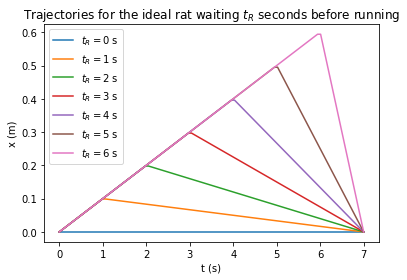

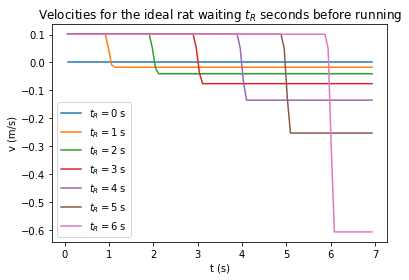

In [2]:
def velocity(x,dt):
    '''This function takes an array of position y (dim=n) and returns the associated array of velocity (dim=n-2)'''
    velocity=np.zeros_like(x)
    for i in range(1,len(x)-1):
        velocity[i]=(x[i+1]-x[i-1])/dt/2
    return(velocity)


def simple_profile(tr):
    '''Creates the simplest linear model for the rats (static until tr and then runs at max speed 
    so that it arrives at precisely 7 seconds)'''
    time=np.linspace(0,7,100)
    x=np.zeros_like(time)
    for i in range(len(time)):
        if time[i]<tr:
            x[i]=vtapis*time[i]
        if tr<=time[i]<=7:
            x[i]=(-vtapis*tr)*time[i]/(7-tr)+vtapis*tr*7/(7-tr)
    return(x)

vtapis=0.1 #10cm/s

for i in range(7):
    plt.plot(np.linspace(0,7,100),simple_profile(i),label=r"$t_R = $"+str(i)+" s")
    
plt.title(r"Trajectories for the ideal rat waiting $t_R$ seconds before running")
plt.ylabel("x (m)")
plt.xlabel("t (s)")
plt.legend()
plt.show()


for i in range(7):
    plt.plot(np.linspace(0,7,100)[1:99],velocity(simple_profile(i),0.07)[1:99],label=r"$t_R = $"+str(i)+" s")
    
plt.title(r"Velocities for the ideal rat waiting $t_R$ seconds before running")
plt.ylabel("v (m/s)")
plt.xlabel("t (s)")
plt.legend()
plt.show()

## Physical cost
> Now that we have a set of trajectories and velocities, we can try to estimate the cost associated to each path. There exist several models describing the energy loss during effort. It seems that in most cases, the power law can be written as a quadratic function of the velocity: $\dot{E}=av^2+b$. In his 1958 paper, Ralston derived the following power law for people performing a walking task:
$$\dot{E}_W = 29+0.0053 v^2 \quad \textrm{cal/kg/min}$$
For a rat with $m_r = 0.3$ kg, we have:
$$\dot{E} = 0.61+1.109\times 10^{-4} v^2 \quad \textrm{J/s}$$
Let's assume $a=1.109\times 10^{-4}$ J.s.m$^{-2}$ and $b=0.61$ J.$s^{-1}$ for now. Ralston noticed a discrepancy between the energy loss of people simply standing (about $21$ J/s/kg) and people walking as slowly as possible ($v\rightarrow 0$, $\dot{E}\rightarrow 29$ J/s/kg). This discrepancy should be taken into account: the physical cost of standing still is significantly lower than that of slow walking. 

> The cost can be written as:
$$E = \int_{0}^7 \dot{E} dt = \int_0^{t_R} \textrm{metabolic rate}.dt + \int_{t_R}^7 (a v_{max}^2+b)dt$$
>Since $v_{max} = \frac{v_t t_R}{7-t_R}+v_t$, we can solve it analytically and obtain:
$$E = b(7-t_R)+\textrm{MR}t_R+\frac{49 a v_t^2}{7-t_R}$$

Let's evaluate this cost for the different trajectories (computed previously), and let's keep the metabolic rate as an unknown. Logically, this metabolic rate should never be bigger than b, the energy loss when one's walking asymptotically slowly, but let's still compute energy costs with some $\textrm{MR}>b$. 

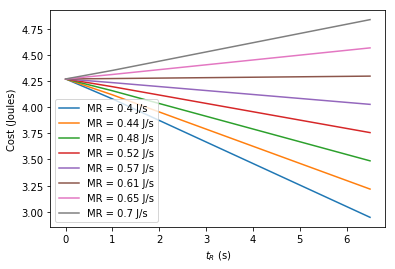

In [3]:
dt=0.07 #100 pts correspond to 7 seconds

def cost(velocity,epsilon):
    '''This function computes the cost of a velocity profile according to a Raltson's quadratic power law. There is 
    a discontinuity between the steady state and very slow motion (following Ralston a=1.109E-04 J.s/m², b=0.61 J/s
    for m=0.3 kg). The metabolic rate (mr) is kept free.'''
    cost=0
    a=1.109E-04
    b=0.61
    for i in range(len(velocity)):
        if np.abs(velocity[i]-vtapis)<epsilon:
            cost+=ssp*dt
        else:
            cost+=(a*(velocity[i]-vtapis)**2+b)*dt
    return(cost)

costarray=[]
times=[0,1,2,3,4,5,6,6.5]
steadystate=np.linspace(0.4,0.7,8) #let's see the results for a range of metabolic rates

for ssp in steadystate:
    for t in times:
        costarray.append(cost(velocity(simple_profile(t),0.07),0.01))
    plt.plot(times,costarray,label='MR = '+str(ssp)[:4]+' J/s')
    plt.xlabel("$t_R$ (s)")
    plt.ylabel('Cost (Joules)')
    plt.legend()
    costarray=[]

>What we can get from this computation is that for likely scenari ($\textrm{MR} < b$), the trend is always the same. The more the rat waits, the lower the energy cost. For unrealistic metabolic rates, there is a branching, the trend is reversed. In the special case that $\textrm{MR} = b$, the cost is constant as a function of $t_R$ (the time at which the rat starts running), which highlights how small the velocity contribution is in this power law. 

>In the following, let's take $\textrm{MR} = 0.43$ J/s. Let's evaluate the influence of the parameter $a$. 

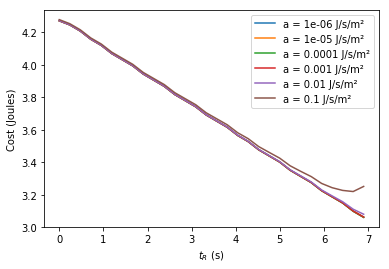

In [4]:
def cost(velocity,epsilon):
    '''This function computes the cost of a velocity profile according to a Raltson's quadratic power law. There is 
    a discontinuity between the steady state and very slow motion (following Ralston b=0.61 J/s, a is kept free, 
    mr = 0.43 J/s, for m=0.3 kg)'''
    cost=0
    b=0.61
    mr=0.43
    for i in range(len(velocity)):
        if np.abs(velocity[i]-vtapis)<epsilon:
            cost+=mr*dt
        else:
            cost+=(a*(velocity[i]-vtapis)**2+b)*dt
    return(cost)

costarray=[]
times=np.linspace(0,6.9,30)
acoef=[1.0E-06,1.0E-05,1.0E-04,1.0E-03,1.0E-02,1.0E-01] #let's see the results for a range of metabolic rates

for a in acoef:
    for t in times:
        costarray.append(cost(velocity(simple_profile(t),0.07),0.01))
    plt.plot(times,costarray,label='a = '+str(a)[:8]+' J/s/m²')
    plt.xlabel("$t_R$ (s)")
    plt.ylabel('Cost (Joules)')
    plt.legend()
    costarray=[]

> The influence of the velocity on the cost starts becoming noticeable for $a=0.1$ J/s/m² (beginning of a bifurcation), which is 1000 times the value found by Ralston. We can assume that his value is reasonable, and the power law stable. 

>Finally, using parameters $a=1.101\times 10^{-4}$ J/s/m², $b=0.61$ J/s, $\textrm{MR}=0.43$ J/s:

Text(0, 0.5, 'Cost (Joules)')

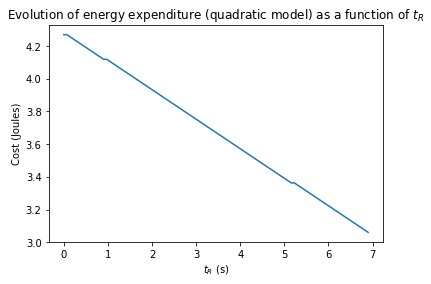

In [5]:
def cost(velocity,epsilon):
    '''This function computes the cost of a velocity profile according to a Raltson's quadratic power law. There is 
    a discontinuity between the steady state and very slow motion (following Ralston b=0.61 J/s, a is kept free, 
    mr = 0.43 J/s, for m=0.3 kg)'''
    cost=0
    a=1.109E-04
    b=0.61
    mr=0.43
    for i in range(len(velocity)):
        if np.abs(velocity[i]-vtapis)<epsilon:
            cost+=mr*dt
        else:
            cost+=(a*(velocity[i]-vtapis)**2+b)*dt
    return(cost)

times=np.linspace(0,6.9,100)
costarray=[]

for t in times:
    costarray.append(cost(velocity(simple_profile(t),0.07),0.01))

plt.plot(times,costarray)
plt.title("Evolution of energy expenditure (quadratic model) as a function of $t_R$")
plt.xlabel("$t_R$ (s)")
plt.ylabel('Cost (Joules)')


## Linear model for the physical cost

Heglund, Cavagna & Taylor (1981) derived a power law linear in the velocity for all mammals. The weight of the velocity contribution is much higher than in the quadratic model and leads to a slightly different curve ($m=0.3$ kg): 

$$\dot{E} = 0.2055 v_g + 0.0216$$

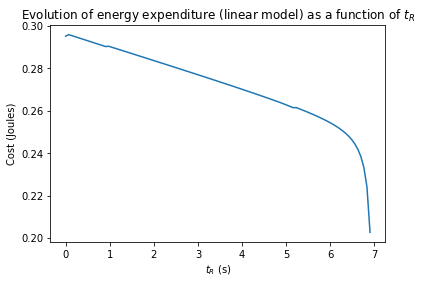

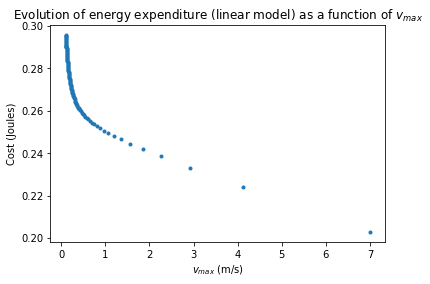

In [6]:
def cost_linear(velocity,epsilon,a,b,mr):
    '''This function computes the cost of a velocity profile according to Cavagna's linear power law.''' 
    cost=0
    for i in range(len(velocity)):
        if np.abs(velocity[i]-vtapis)<epsilon:
            cost+=mr*dt
        else:
            cost+=(a*np.abs(velocity[i]-vtapis)+b)*dt
    return(cost)

times=np.linspace(0,6.9,100)
costarray=[]

for t in times:
    costarray.append(cost_linear(velocity(simple_profile(t),0.07),0.01,0.2055,0.0216,0.015))

plt.plot(times,costarray)
plt.title("Evolution of energy expenditure (linear model) as a function of $t_R$")
plt.xlabel("$t_R$ (s)")
plt.ylabel('Cost (Joules)')    
plt.show()    
    
velocitymax=[vtapis*t/(7-t)+vtapis for t in times]
plt.plot(velocitymax,costarray,'.')
plt.title("Evolution of energy expenditure (linear model) as a function of $v_{max}$")
plt.xlabel("$v_{max}$ (m/s)")
plt.ylabel('Cost (Joules)')
plt.show()

> With this new power law, the energy cost exhibits a different behavior at high $t_R$ (and consequently high velocities). The total cost still decreases as $t_R$ increases. The decrease in cost is very high when the (full-speed) velocity is increased from 0 m.s$^{-1}$ to about 1 m.s$^{-1}$. To keep decreasing the cost, the rat must run at an ever faster velocity (for a smaller and smaller cost reduction). 

> Let's play with parameters $a$, $b$ and MR, to check the stability of our conclusions. Firstly, let's change the value of a:

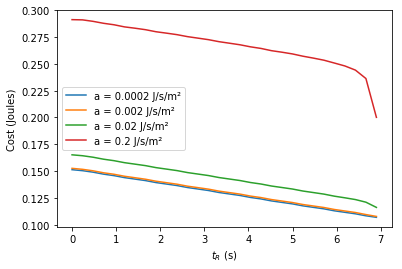

In [7]:
costarray=[]
times=np.linspace(0,6.9,30)
acoef=[0.0002,0.002,0.02,0.2] #let's see the results for a range of metabolic rates

for a in acoef:
    for t in times:
        costarray.append(cost_linear(velocity(simple_profile(t),0.07),0.01,a,0.0216,0.015))
    plt.plot(times,costarray,label='a = '+str(a)[:8]+' J/s/m²')
    plt.xlabel("$t_R$ (s)")
    plt.ylabel('Cost (Joules)')
    plt.legend()
    costarray=[]

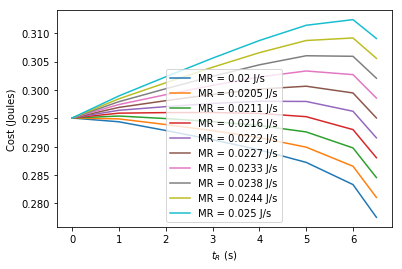

In [8]:
costarray=[]
times=[0,1,2,3,4,5,6,6.5]
steadystate=np.linspace(0.020,0.025,10) #let's see the results for a range of metabolic rates

for ssp in steadystate:
    for t in times:
        costarray.append(cost_linear(velocity(simple_profile(t),0.07),0.01,0.2055,0.0216,ssp))
    plt.plot(times,costarray,label='MR = '+str(ssp)[:6]+' J/s')
    plt.xlabel("$t_R$ (s)")
    plt.ylabel('Cost (Joules)')
    plt.legend()
    costarray=[]

# Data analysis: DO NOT READ THIS YET

In [9]:
dt=0.04
vtapis=0.1 #10cm/s ? to be adjusted with real value

def position(data):
    '''This function creates a position array out of a data file'''
    position=[]
    inp = open (data,"r")
    for line in inp.readlines():
        linelement=line.split( )
        for element in linelement:
            position.append(float(element))
    position = [0.01*element for element in position]
    return(position)

def velocity(x,dt):
    '''This function takes an array of position y (dim=n) and returns the associated array of velocity (dim=n-2)'''
    velocity=np.zeros_like(x)
    for i in range(1,len(x)-1):
        velocity[i]=(x[i+1]-x[i-1])/dt/2
    return(velocity)

def time(array):
    '''This function computes automatically the time array (x) for a set of data (y)'''
    return(np.linspace(0,len(array)*0.04,len(array)))

def plot(array,llabel):
    return(plt.plot(time(array),array,'-',label=llabel))

def cost(velocity,epsilon):
    '''This function computes the cost of a velocity profile according to a linear power law. There is 
    a discontinuity between the steady state and very slow motion (following Ralston a=1.109E-04 J.s/m², b=0.61 J/s
    for m=0.3 kg)'''
    cost=0
    a=1.109E-04
    b=0.61
    ssp=0.60
    for i in range(len(velocity)):
        if np.abs(velocity[i]-vtapis)<epsilon:
            cost+=ssp*dt
        else:
            cost+=(a*(velocity[i]-vtapis)**2+b)*dt
    return(cost)
    
            

# Experimental data

In this section, I am plotting the position profiles (and the associated velocity profiles) for 5 different experimental cases: control, dls, dms, ds. 

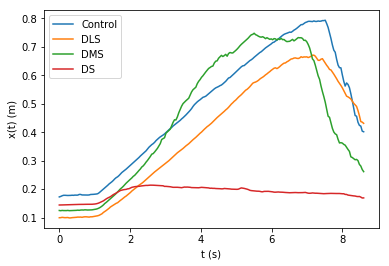

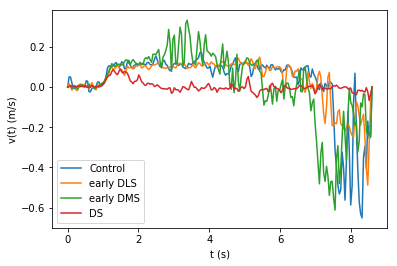

In [11]:
positionc=position("Data/control.txt")[0:215]
positiondls=position("Data/dls.txt")[0:215]
positiondms=position("Data/dms.txt")[0:215]
positionds=position("Data/ds.txt")[0:215]


plot(positionc,"Control")
plot(positiondls,"DLS")
plot(positiondms,"DMS")
plot(positionds,"DS")
plt.ylabel('x(t) (m)')
plt.xlabel('t (s)')
plt.legend()
plt.show()

velocityc=velocity(positionc,dt)
velocitydls=velocity(positiondls,dt)
velocitydms=velocity(positiondms,dt)
velocityds=velocity(positionds,dt)

plot(velocityc,"Control")
plot(velocitydls,"early DLS")
plot(velocitydms,"early DMS")
plot(velocityds,"DS")
plt.ylabel('v(t) (m/s)')
plt.xlabel('t (s)')
plt.legend()
plt.show()

# Smoothing the curves

In this section, I am working on a code that can smooth the velocity profiles (this step is not necessary). 

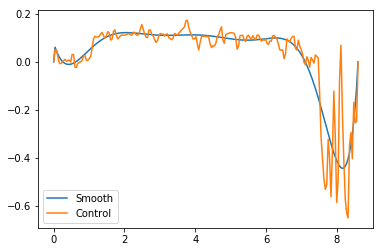

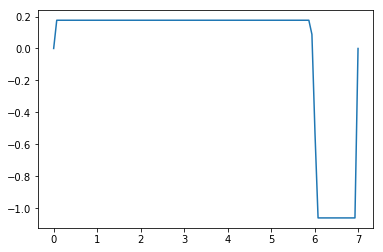

In [12]:
poly = np.polyfit(time(positionc),positionc,10)
poly_y = np.poly1d(poly)(time(positionc))
v=velocity(poly_y,dt)
plot(v,"Smooth")
plot(velocityc,"Control")
plt.legend()
#plt.plot(time(positionc),positionc)
plt.show()


def simple_profile(tr):
    '''Creates the simplest linear model for the rats (static until tr and then runs at max speed 
    so that it arrives at precisely 7 seconds)'''
    time=np.linspace(0,7,100)
    x=np.zeros_like(time)
    for i in range(len(time)):
        if time[i]<tr:
            x[i]=vtapis*time[i]
        if tr<=time[i]<=7:
            x[i]=(-vtapis*tr)*time[i]/(7-tr)+vtapis*tr*7/(7-tr)
    return(x)

vtapis=0.1
x=simple_profile(6)
v=velocity(x,dt)
plt.plot(np.linspace(0,7,100),v)
plt.show()

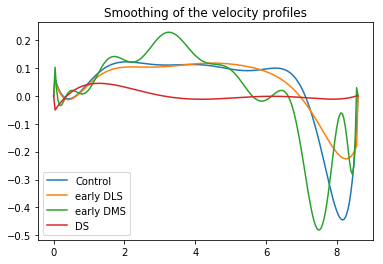

In [13]:
vc=velocity(np.poly1d(np.polyfit(time(positionc),positionc,10))(time(positionc)),dt)
vdls=velocity(np.poly1d(np.polyfit(time(positiondls),positiondls,10))(time(positiondls)),dt)
vdms=velocity(np.poly1d(np.polyfit(time(positiondms),positiondms,15))(time(positiondms)),dt)
vds=velocity(np.poly1d(np.polyfit(time(positionds),positionds,6))(time(positionds)),dt)

plot(vc,"Control")
plot(vdls,"early DLS")
plot(vdms,"early DMS")
plot(vds,"DS")
plt.title("Smoothing of the velocity profiles")
plt.legend()
#plt.plot(time(positionc),positionc)
plt.show()

# Testing different power laws

In this section I will compute the cost $J=\int(av^\alpha+b) dt$, against parameter $\alpha$. The value $\alpha=2$ has been found experimentally for different animals, including man. Good values for $a$ and $b$ have to be determined. In Ralston's 1958 paper:
$$\dot{E}_W = 29+0.0053 v^2 \quad \textrm{cal/kg/min}$$
For a rat with $m_r = 0.3$ kg, we have:
$$\dot{E} = 0.61+1.109\times 10^{-4} v^2 \quad \textrm{J/s}$$

alpha =  [1.         1.10526316 1.21052632 1.31578947 1.42105263 1.52631579
 1.63157895 1.73684211 1.84210526 1.94736842 2.05263158 2.15789474
 2.26315789 2.36842105 2.47368421 2.57894737 2.68421053 2.78947368
 2.89473684 3.        ]


Text(0, 0.5, 'J')

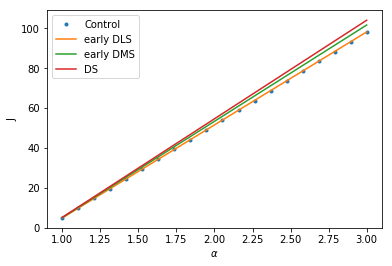

In [14]:
def costalpha(velocity,alpha,epsilon):
    '''This function takes a velocity profile and computes the energy loss according to some law a*v**alpha+b
    where alpha is given as a list, a is an empirical value for the energy loss in motion, b is the steady 
    state energy loss (can be easily measured for a given rat knowing the mass evolution at rest 
    (no feeding/drinking)). The output is the energy loss computed for each alpha.'''
    cost=0 #initialize cost
    acoef=1.109E-04
    b=0.61
    ssp=0.55
    costalpha=[]
    for a in alpha:
        for i in range(len(velocity)):
            if np.abs(velocity[i]-vtapis)<epsilon: #criterion for steady state
                cost+=ssp*dt 
            else:
                cost+=((acoef*np.abs((velocity[i])-vtapis))**int(a)+b)*dt #energy loss during effort, 
                #v is the relative velocity of the rat
        costalpha.append(cost)
    return(costalpha)

alpha=np.linspace(1,3,20)
print("alpha = ",alpha)
jalphac=costalpha(velocityc,alpha,0.05)
jalphadls=costalpha(velocitydls,alpha,0.05)
jalphadms=costalpha(velocitydms,alpha,0.05)
jalphads=costalpha(velocityds,alpha,0.05)

plt.plot(alpha,jalphac,'.',label='Control')
plt.plot(alpha,jalphadls,label="early DLS")
plt.plot(alpha,jalphadms,label="early DMS")
plt.plot(alpha,jalphads,label='DS')
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel("J")

Small computation of the energy expenditure of the rats during the task using Raltson's law:

In [15]:
costc = cost(velocityc,0.05)
costdls = cost(velocitydls,0.05)
costds = cost(velocityds,0.05)
costdms = cost(velocitydms,0.05)

print("For Control, J = ",costc," J")
print("For DLS, J = ",costdls," J")
print("For DS, J = ",costds," J")
print("For DMS, J = ",costdms," J")

For Control, J =  5.1892309552380524  J
For DLS, J =  5.190014615236552  J
For DS, J =  5.238809519726982  J
For DMS, J =  5.218837185776791  J
